ENERGY ARBITRAGE VALUE ANALYSIS including price forecasts with XGB model instead of perfect foresight prices for year 2017.

In [1]:
##############################
## IMPORT AND PREPARE DATA ##
############################
import numpy as np
import pandas as pd
from datetime import datetime
from typing import List
from pyomo.environ import *

# Import data
filename1 = 'HOEP_2015-2019_dataset.csv'
XGboost_2017 = pd.read_csv('HOEP_2017_forecast_XGB1.csv')
XGboost6_2017 = pd.read_csv('HOEP_2017_forecast_XGB6.csv')
XGboost12_2017 = pd.read_csv('HOEP_2017_forecast_XGB12.csv')
XGboost13_2017 = pd.read_csv('HOEP_2017_forecast_XGB13.csv')
XGboost24_2017 = pd.read_csv('HOEP_2017_forecast_XGB24.csv')

dataframe = pd.read_csv(filename1)
cols_of_interest = ["Date","Hour","HOEP"]
dataframe = dataframe[cols_of_interest]

dataframe['HOEP_lag360'] = dataframe.HOEP.shift(360)
dataframe['HOEP_lag168'] = dataframe.HOEP.shift(168)
dataframe['HOEP_lag24'] = dataframe.HOEP.shift(24)
dataframe['Datetime'] = pd.to_datetime(dataframe.Date) + pd.to_timedelta(dataframe.Hour, unit='h')

df_2017 = dataframe.loc[17544:26663].reset_index(drop=True)
df_2017['XGB'] = XGboost_2017.Forecast
df_2017['XGB6'] = XGboost6_2017.Forecast
df_2017['XGB12'] = XGboost12_2017.Forecast
df_2017['XGB13'] = XGboost13_2017.Forecast
df_2017['XGB24'] = XGboost24_2017.Forecast

data = df_2017.copy()
data = data.fillna(0)
data

,Date,Hour,HOEP,HOEP_lag360,HOEP_lag168,HOEP_lag24,Datetime,XGB,XGB6,XGB12,XGB13,XGB24
0,2017-01-01,1,0.00,37.76,9.54,13.68,2017-01-01 01:00:00,0.418567,0.709859,0.453048,1.476467,4.220757
1,2017-01-01,2,0.00,0.00,-1.77,8.94,2017-01-01 02:00:00,0.418567,0.470547,0.430305,0.799963,3.231945
2,2017-01-01,3,0.00,1.61,-3.00,5.41,2017-01-01 03:00:00,0.288802,-0.270131,0.107990,0.729725,3.228531
3,2017-01-01,4,0.00,30.74,-3.00,0.00,2017-01-01 04:00:00,0.288802,-0.322577,0.107990,0.585232,0.415699
4,2017-01-01,5,0.00,39.59,-0.65,0.00,2017-01-01 05:00:00,0.288802,12.460075,0.107990,0.585232,0.415699
...,...,...,...,...,...,...,...,...,...,...,...,...
9115,2018-01-15,20,88.58,40.04,12.47,59.32,2018-01-15 20:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
9116,2018-01-15,21,317.77,39.71,10.41,97.07,2018-01-15 21:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
9117,2018-01-15,22,69.70,39.37,12.97,65.37,2018-01-15 22:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
9118,2018-01-15,23,50.22,39.79,0.00,57.16,2018-01-15 23:00:00,0.000000,0.000000,0.000000,0.000000,0.000000


In [2]:
########################################################################################
####################################  2017 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 1 (M1) price forecast ###
#######################################################################################

# M1 2017, horizon = 12h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB12 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 11
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 

    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    model.eta = Param(initialize=0.86)

    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB12']               
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('glpk')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB12 = list(df['XGB12'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB12.append(XGB12)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB12'] = list_XGB12
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2017 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 0:13:35.733626
real value of storage: 36.769690000000004


,Datetime,HOEP,XGB,XGB12,Ein,Eout,SOC,value,real_value
0,2017-01-01 01:00:00,0.00,0.42,0.45,0.0,1.00,6.00,0.42,0.00
1,2017-01-01 02:00:00,0.00,0.42,0.43,0.0,1.00,5.00,0.42,0.00
2,2017-01-01 03:00:00,0.00,0.29,0.11,1.0,0.00,5.86,-0.29,-0.00
3,2017-01-01 04:00:00,0.00,0.29,0.11,1.0,0.00,6.72,-0.29,-0.00
4,2017-01-01 05:00:00,0.00,0.29,0.11,1.0,0.00,7.58,-0.29,-0.00
...,...,...,...,...,...,...,...,...,...
8755,2017-12-31 20:00:00,40.04,33.99,37.03,0.0,0.00,0.03,0.00,0.00
8756,2017-12-31 21:00:00,39.71,35.29,37.06,0.0,0.02,0.02,0.56,0.63
8757,2017-12-31 22:00:00,39.37,33.58,37.19,0.0,0.01,0.01,0.27,0.31
8758,2017-12-31 23:00:00,39.79,34.57,35.01,0.0,0.00,0.00,0.14,0.16


In [3]:
########################################################################################
####################################  2017 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 2 (M2) price forecast ###
#######################################################################################

# M2 2017, horizon = 24h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB24 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 23
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 

    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    model.eta = Param(initialize=0.86)

    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB24']               
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('glpk')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB24 = list(df['XGB24'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB24.append(XGB24)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB24'] = list_XGB24
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2017 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 0:14:14.073822
real value of storage: 37.751169999999995


,Datetime,HOEP,XGB,XGB24,Ein,Eout,SOC,value,real_value
0,2017-01-01 01:00:00,0.00,0.42,4.22,0.0,1.0,6.00,0.42,0.00
1,2017-01-01 02:00:00,0.00,0.42,3.23,1.0,0.0,6.86,-0.42,-0.00
2,2017-01-01 03:00:00,0.00,0.29,3.23,1.0,0.0,7.72,-0.29,-0.00
3,2017-01-01 04:00:00,0.00,0.29,0.42,1.0,0.0,8.58,-0.29,-0.00
4,2017-01-01 05:00:00,0.00,0.29,0.42,1.0,0.0,9.44,-0.29,-0.00
...,...,...,...,...,...,...,...,...,...
8755,2017-12-31 20:00:00,40.04,33.99,36.20,0.0,0.0,0.00,0.11,0.13
8756,2017-12-31 21:00:00,39.71,35.29,35.48,0.0,0.0,0.00,0.06,0.07
8757,2017-12-31 22:00:00,39.37,33.58,35.36,0.0,0.0,0.00,0.03,0.03
8758,2017-12-31 23:00:00,39.79,34.57,33.71,0.0,0.0,0.00,0.01,0.02


In [4]:
########################################################################################
####################################  2017 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 7 (M7) price forecast ###
#######################################################################################

# M7 2017, horizon = 360h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB12 = []
list_HOEP_lag168 = []
list_HOEP_lag360 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 359
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            if t in range(1,12):
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB12']
            else:
                if t in range(13,168):
                    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag168']
                else:
                    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag360']       
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB12 = list(df['XGB12'])[0]
    HOEP_lag168 = list(df['HOEP_lag168'])[0]
    HOEP_lag360 = list(df['HOEP_lag360'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB12.append(XGB12)
    list_HOEP_lag168.append(HOEP_lag168)
    list_HOEP_lag360.append(HOEP_lag360)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB12'] = list_XGB12
results['HOEP_lag168'] = list_HOEP_lag168
results['HOEP_lag360'] = list_HOEP_lag360
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2017 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 3:03:02.479471
real value of storage: 40.48167


,Datetime,HOEP,XGB,XGB12,HOEP_lag168,HOEP_lag360,Ein,Eout,SOC,value,real_value
0,2017-01-01 01:00:00,0.00,0.42,0.45,9.54,37.76,0.0,1.00,6.00,0.42,0.00
1,2017-01-01 02:00:00,0.00,0.42,0.43,-1.77,0.00,1.0,0.00,6.86,-0.42,-0.00
2,2017-01-01 03:00:00,0.00,0.29,0.11,-3.00,1.61,1.0,0.00,7.72,-0.29,-0.00
3,2017-01-01 04:00:00,0.00,0.29,0.11,-3.00,30.74,1.0,0.00,8.58,-0.29,-0.00
4,2017-01-01 05:00:00,0.00,0.29,0.11,-0.65,39.59,1.0,0.00,9.44,-0.29,-0.00
...,...,...,...,...,...,...,...,...,...,...,...
8755,2017-12-31 20:00:00,40.04,33.99,37.03,7.25,36.89,0.0,0.00,0.03,0.00,0.00
8756,2017-12-31 21:00:00,39.71,35.29,37.06,11.50,38.30,0.0,0.02,0.02,0.60,0.68
8757,2017-12-31 22:00:00,39.37,33.58,37.19,12.72,67.32,0.0,0.01,0.01,0.29,0.34
8758,2017-12-31 23:00:00,39.79,34.57,35.01,12.12,35.17,0.0,0.00,0.00,0.15,0.17


In [5]:
########################################################################################
####################################  2017 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 5 (M5) price forecast ###
#######################################################################################

# M5 2017, horizon = 360h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB24 = []
list_HOEP_lag168 = []
list_HOEP_lag360 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 359
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            if t in range(1,24):
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB24']
            else:
                if t in range(24,168):
                    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag168']
                else:
                    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag360']       
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB24 = list(df['XGB24'])[0]
    HOEP_lag168 = list(df['HOEP_lag168'])[0]
    HOEP_lag360 = list(df['HOEP_lag360'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB24.append(XGB24)
    list_HOEP_lag168.append(HOEP_lag168)
    list_HOEP_lag360.append(HOEP_lag360)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB24'] = list_XGB24
results['HOEP_lag168'] = list_HOEP_lag168
results['HOEP_lag360'] = list_HOEP_lag360
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2017 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 2:00:59.572750
real value of storage: 38.25144


,Datetime,HOEP,XGB,XGB24,HOEP_lag168,HOEP_lag360,Ein,Eout,SOC,value,real_value
0,2017-01-01 01:00:00,0.00,0.42,4.22,9.54,37.76,0.0,1.0,6.00,0.42,0.00
1,2017-01-01 02:00:00,0.00,0.42,3.23,-1.77,0.00,1.0,0.0,6.86,-0.42,-0.00
2,2017-01-01 03:00:00,0.00,0.29,3.23,-3.00,1.61,1.0,0.0,7.72,-0.29,-0.00
3,2017-01-01 04:00:00,0.00,0.29,0.42,-3.00,30.74,1.0,0.0,8.58,-0.29,-0.00
4,2017-01-01 05:00:00,0.00,0.29,0.42,-0.65,39.59,1.0,0.0,9.44,-0.29,-0.00
...,...,...,...,...,...,...,...,...,...,...,...
8755,2017-12-31 20:00:00,40.04,33.99,36.20,7.25,36.89,0.0,0.0,0.00,0.12,0.15
8756,2017-12-31 21:00:00,39.71,35.29,35.48,11.50,38.30,0.0,0.0,0.00,0.06,0.07
8757,2017-12-31 22:00:00,39.37,33.58,35.36,12.72,67.32,0.0,0.0,0.00,0.03,0.04
8758,2017-12-31 23:00:00,39.79,34.57,33.71,12.12,35.17,0.0,0.0,0.00,0.02,0.02


In [6]:
########################################################################################
####################################  2017 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 4 (M4) price forecast ###
#######################################################################################

# M4 2017, horizon = 168h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB12 = []
list_HOEP_lag168 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 167
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            if t in range(1,12):
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB12']
            else:
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag168']       
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB12 = list(df['XGB12'])[0]
    HOEP_lag168 = list(df['HOEP_lag168'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB12.append(XGB12)
    list_HOEP_lag168.append(HOEP_lag168)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB12'] = list_XGB12
results['HOEP_lag168'] = list_HOEP_lag168
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2017 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 1:16:03.441682
real value of storage: 40.4021


,Datetime,HOEP,XGB,XGB12,HOEP_lag168,Ein,Eout,SOC,value,real_value
0,2017-01-01 01:00:00,0.00,0.42,0.45,9.54,0.00,1.00,6.00,0.42,0.00
1,2017-01-01 02:00:00,0.00,0.42,0.43,-1.77,0.81,0.00,6.70,-0.34,-0.00
2,2017-01-01 03:00:00,0.00,0.29,0.11,-3.00,1.00,0.00,7.56,-0.29,-0.00
3,2017-01-01 04:00:00,0.00,0.29,0.11,-3.00,1.00,0.00,8.42,-0.29,-0.00
4,2017-01-01 05:00:00,0.00,0.29,0.11,-0.65,1.00,0.00,9.28,-0.29,-0.00
...,...,...,...,...,...,...,...,...,...,...
8755,2017-12-31 20:00:00,40.04,33.99,37.03,7.25,0.00,0.00,0.03,0.00,0.00
8756,2017-12-31 21:00:00,39.71,35.29,37.06,11.50,0.00,0.02,0.02,0.60,0.68
8757,2017-12-31 22:00:00,39.37,33.58,37.19,12.72,0.00,0.01,0.01,0.29,0.34
8758,2017-12-31 23:00:00,39.79,34.57,35.01,12.12,0.00,0.00,0.00,0.15,0.17


In [6]:
################################################################
############################## 2017 ############################
### OPTIMIZATION WITH 1,24h XGBoost rolling horizon OF THE PRICE and HOEP_lag168
###################################################################
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB24 = []
list_HOEP_lag168 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 167
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            if t in range(1,24):
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB24']
            else:
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag168']       
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB24 = list(df['XGB24'])[0]
    HOEP_lag168 = list(df['HOEP_lag168'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB24.append(XGB24)
    list_HOEP_lag168.append(HOEP_lag168)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB24'] = list_XGB24
results['HOEP_lag168'] = list_HOEP_lag168
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2017 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 1:05:24.805182
real value of storage: 38.251450000000006


,Datetime,HOEP,XGB,XGB24,HOEP_lag168,Ein,Eout,SOC,value,real_value
0,2017-01-01 01:00:00,0.00,0.42,4.22,9.54,0.0,1.0,6.00,0.42,0.00
1,2017-01-01 02:00:00,0.00,0.42,3.23,-1.77,1.0,0.0,6.86,-0.42,-0.00
2,2017-01-01 03:00:00,0.00,0.29,3.23,-3.00,1.0,0.0,7.72,-0.29,-0.00
3,2017-01-01 04:00:00,0.00,0.29,0.42,-3.00,1.0,0.0,8.58,-0.29,-0.00
4,2017-01-01 05:00:00,0.00,0.29,0.42,-0.65,1.0,0.0,9.44,-0.29,-0.00
...,...,...,...,...,...,...,...,...,...,...
8755,2017-12-31 20:00:00,40.04,33.99,36.20,7.25,0.0,0.0,0.00,0.12,0.15
8756,2017-12-31 21:00:00,39.71,35.29,35.48,11.50,0.0,0.0,0.00,0.06,0.07
8757,2017-12-31 22:00:00,39.37,33.58,35.36,12.72,0.0,0.0,0.00,0.03,0.04
8758,2017-12-31 23:00:00,39.79,34.57,33.71,12.12,0.0,0.0,0.00,0.02,0.02


In [7]:
########################################################################################
####################################  2017 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 3 (M3) price forecast ###
#######################################################################################

# M3 2017, horizon = 168h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB12 = []
list_HOEP_lag168 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 167
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t in range(0,12):
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB12']
        else:
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag168']      
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB12 = list(df['XGB12'])[0]
    HOEP_lag168 = list(df['HOEP_lag168'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB12.append(XGB12)
    list_HOEP_lag168.append(HOEP_lag168)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB12'] = list_XGB12
results['HOEP_lag168'] = list_HOEP_lag168
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2017 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 1:07:09.295453
real value of storage: 22.899769462553557


,Datetime,HOEP,XGB12,HOEP_lag168,Ein,Eout,SOC,value,real_value
0,2017-01-01 01:00:00,0.00,0.45,9.54,0.00,1.00,6.00,0.45,0.00
1,2017-01-01 02:00:00,0.00,0.43,-1.77,0.17,0.00,6.14,-0.07,-0.00
2,2017-01-01 03:00:00,0.00,0.11,-3.00,1.00,0.00,7.00,-0.11,-0.00
3,2017-01-01 04:00:00,0.00,0.11,-3.00,1.00,0.00,7.86,-0.11,-0.00
4,2017-01-01 05:00:00,0.00,0.11,-0.65,1.00,0.00,8.72,-0.11,-0.00
...,...,...,...,...,...,...,...,...,...
8755,2017-12-31 20:00:00,40.04,37.03,7.25,0.00,1.00,2.00,37.03,40.04
8756,2017-12-31 21:00:00,39.71,37.06,11.50,0.00,1.00,1.00,37.06,39.71
8757,2017-12-31 22:00:00,39.37,37.19,12.72,0.00,0.50,0.50,18.59,19.69
8758,2017-12-31 23:00:00,39.79,35.01,12.12,0.00,0.25,0.25,8.75,9.95


In [3]:
########################################################################################
####################################  2017 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 9 (M9) price forecast ###
#######################################################################################

# M9 2017, horizon = 168h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB12 = []
list_XGB24 = []
list_HOEP_lag168 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 167
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            if t in range(1,12):
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB12']
            else:
                if t in range(12,24):
                    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB24']
                else:
                    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag168']      
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB12 = list(df['XGB12'])[0]
    XGB24 = list(df['XGB24'])[0]
    HOEP_lag168 = list(df['HOEP_lag168'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB12.append(XGB12)
    list_XGB24.append(XGB24)
    list_HOEP_lag168.append(HOEP_lag168)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB12'] = list_XGB12
results['XGB24'] = list_XGB24
results['HOEP_lag168'] = list_HOEP_lag168
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2017 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 1:09:17.457323
real value of storage: 41.65772886048345


,Datetime,HOEP,XGB,XGB12,XGB24,HOEP_lag168,Ein,Eout,SOC,value,real_value
0,2017-01-01 01:00:00,0.00,0.42,0.45,4.22,9.54,0.0,1.00,6.00,0.42,0.00
1,2017-01-01 02:00:00,0.00,0.42,0.43,3.23,-1.77,1.0,0.00,6.86,-0.42,-0.00
2,2017-01-01 03:00:00,0.00,0.29,0.11,3.23,-3.00,1.0,0.00,7.72,-0.29,-0.00
3,2017-01-01 04:00:00,0.00,0.29,0.11,0.42,-3.00,1.0,0.00,8.58,-0.29,-0.00
4,2017-01-01 05:00:00,0.00,0.29,0.11,0.42,-0.65,1.0,0.00,9.44,-0.29,-0.00
...,...,...,...,...,...,...,...,...,...,...,...
8755,2017-12-31 20:00:00,40.04,33.99,37.03,36.20,7.25,0.0,0.00,0.12,0.00,0.00
8756,2017-12-31 21:00:00,39.71,35.29,37.06,35.48,11.50,0.0,0.06,0.06,2.21,2.48
8757,2017-12-31 22:00:00,39.37,33.58,37.19,35.36,12.72,0.0,0.03,0.03,1.05,1.23
8758,2017-12-31 23:00:00,39.79,34.57,35.01,33.71,12.12,0.0,0.02,0.02,0.54,0.62


In [2]:
########################################################################################
####################################  2017 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 8 (M8) price forecast ###
#######################################################################################

# M8 2017, horizon = 360h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB12 = []
list_XGB24 = []
list_HOEP_lag168 = []
list_HOEP_lag360 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 359
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            if t in range(1,12):
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB12']
            else:
                if t in range(12,24):
                    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB24']
                else:
                    if t in range(24,168):
                        return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag168']
                    else:
                        return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag360']       
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB12 = list(df['XGB12'])[0]
    XGB24 = list(df['XGB24'])[0]
    HOEP_lag168 = list(df['HOEP_lag168'])[0]
    HOEP_lag360 = list(df['HOEP_lag360'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB12.append(XGB12)
    list_XGB24.append(XGB24)
    list_HOEP_lag168.append(HOEP_lag168)
    list_HOEP_lag360.append(HOEP_lag360)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB12'] = list_XGB12
results['XGB24'] = list_XGB24
results['HOEP_lag168'] = list_HOEP_lag168
results['HOEP_lag360'] = list_HOEP_lag360
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2017 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 2:23:47.164799
real value of storage: 41.65773886048345


,Datetime,HOEP,XGB,XGB12,XGB24,HOEP_lag168,HOEP_lag360,Ein,Eout,SOC,value,real_value
0,2017-01-01 01:00:00,0.00,0.42,0.45,4.22,9.54,37.76,0.0,1.00,6.00,0.42,0.00
1,2017-01-01 02:00:00,0.00,0.42,0.43,3.23,-1.77,0.00,1.0,0.00,6.86,-0.42,-0.00
2,2017-01-01 03:00:00,0.00,0.29,0.11,3.23,-3.00,1.61,1.0,0.00,7.72,-0.29,-0.00
3,2017-01-01 04:00:00,0.00,0.29,0.11,0.42,-3.00,30.74,1.0,0.00,8.58,-0.29,-0.00
4,2017-01-01 05:00:00,0.00,0.29,0.11,0.42,-0.65,39.59,1.0,0.00,9.44,-0.29,-0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2017-12-31 20:00:00,40.04,33.99,37.03,36.20,7.25,36.89,0.0,0.00,0.12,0.00,0.00
8756,2017-12-31 21:00:00,39.71,35.29,37.06,35.48,11.50,38.30,0.0,0.06,0.06,2.21,2.48
8757,2017-12-31 22:00:00,39.37,33.58,37.19,35.36,12.72,67.32,0.0,0.03,0.03,1.05,1.23
8758,2017-12-31 23:00:00,39.79,34.57,35.01,33.71,12.12,35.17,0.0,0.02,0.02,0.54,0.62


In [3]:
########################################################################################
####################################  2017 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 6 (M6) price forecast ###
#######################################################################################

# M6 2017, horizon = 168h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB6 = []
list_XGB12 = []
list_XGB24 = []
list_HOEP_lag168 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 167
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            if t in range(1,6):
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB6']
            else:
                if t in range(6,12):
                    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB12']
                else:
                    if t in range(12,24):
                        return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB24']
                    else:
                        return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag168']       
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB6 = list(df['XGB6'])[0]
    XGB12 = list(df['XGB12'])[0]
    XGB24 = list(df['XGB24'])[0]
    HOEP_lag168 = list(df['HOEP_lag168'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB6.append(XGB6)
    list_XGB12.append(XGB12)
    list_XGB24.append(XGB24)
    list_HOEP_lag168.append(HOEP_lag168)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB6'] = list_XGB6
results['XGB12'] = list_XGB12
results['XGB24'] = list_XGB24
results['HOEP_lag168'] = list_HOEP_lag168
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2017 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 1:10:11.091718
real value of storage: 41.42106


,Datetime,HOEP,XGB,XGB6,XGB12,XGB24,HOEP_lag168,Ein,Eout,SOC,value,real_value
0,2017-01-01 01:00:00,0.00,0.42,0.71,0.45,4.22,9.54,0.0,1.00,6.00,0.42,0.00
1,2017-01-01 02:00:00,0.00,0.42,0.47,0.43,3.23,-1.77,1.0,0.00,6.86,-0.42,-0.00
2,2017-01-01 03:00:00,0.00,0.29,-0.27,0.11,3.23,-3.00,1.0,0.00,7.72,-0.29,-0.00
3,2017-01-01 04:00:00,0.00,0.29,-0.32,0.11,0.42,-3.00,1.0,0.00,8.58,-0.29,-0.00
4,2017-01-01 05:00:00,0.00,0.29,12.46,0.11,0.42,-0.65,1.0,0.00,9.44,-0.29,-0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2017-12-31 20:00:00,40.04,33.99,32.53,37.03,36.20,7.25,0.0,0.01,0.01,0.46,0.54
8756,2017-12-31 21:00:00,39.71,35.29,31.30,37.06,35.48,11.50,0.0,0.01,0.01,0.24,0.27
8757,2017-12-31 22:00:00,39.37,33.58,32.60,37.19,35.36,12.72,0.0,0.00,0.00,0.11,0.13
8758,2017-12-31 23:00:00,39.79,34.57,35.50,35.01,33.71,12.12,0.0,0.00,0.00,0.06,0.07


In [ ]:
###################################################################################################
######## The next optimization models use historical price data instead of XGB price forecasts ###
##################################################################################################

# This is done in order to compare results with Sioshansi et al.

In [3]:
##########################################
#################  2017 ##################
### OPTIMIZATION WITH 1 WEEK PLANNING ###
##########################################

## results shown in Table 5.2 in the thesis (HOEP retardé 24h)
start_time = datetime.now()

list_horizons = ["1d","7d", "14d", "12h", "2d"]
horizon = list_horizons[0]

dataframe = df_2017.copy()  # choose the year of data we want to optimize for
dataframe = dataframe.reset_index(drop=True)

df = dataframe.loc[:8759]  
df = df.reset_index()

# Créer un DatetimeIndex pour pouvoir utiliser df.groupby et pd.Grouper ensuite
df['Datetime'] = pd.to_datetime(df.Date) + pd.to_timedelta(df.Hour, unit='h')
grouped = df.set_index('Datetime').groupby(pd.Grouper(freq=horizon))

duration = 12
output = []   # create empty lists and store results in it during the loop
Profits = []

for name, group in grouped:
    group.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=group.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  

    # Constraints
    def storage_state(model, t):
        if group['Datetime'].iloc[0] == df.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta -  model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
        
        
    # Objective function and optimization
    income = sum(group.loc[t,'HOEP_lag24'] * model.Eout[t] for t in model.T)
    expenses = sum(group.loc[t,'HOEP_lag24'] * model.Ein[t] for t in model.T)
    profits = (income - expenses) 
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 

    # Extract model output in list
    Date = list(group['Datetime'])
    HOEP = list(group['HOEP'])
    HOEP_lag24 = list(group['HOEP_lag24'])
    output.append([Date, HOEP, HOEP_lag24, model.Ein.get_values().values(), model.Eout.get_values().values(), 
                    model.Z.get_values().values()])
    
    list_SOC = list(model.Z.get_values().values()) # transform the SOC values for each t in a list 
    last_period_end_SOC = list_SOC[-1]  # Extract the SOC for the last t of the period and store it
    
    Profits.append(model.objective())

df_results = pd.DataFrame(output)
df_results.rename(columns = {0: 'Date', 1: 'HOEP', 2:'HOEP_lag24', 3:'Ein', 4:'Eout', 5:'Z', 
                             }, inplace = True)
df_results  # we see that doing just so, the dataframe shape is weird and not the way we want.

# Present final results in dataframe
d = hoep = ein = eout = z = HOEP_lag24 = []  
# create empty list and store content of each 
for i in list(df_results.index):
    d = d + list(df_results.loc[i,'Date'])
    hoep = hoep + list(df_results.loc[i,'HOEP'])
    HOEP_lag24 = HOEP_lag24 + list(df_results.loc[i,'HOEP_lag24'])
    ein = ein + list(df_results.loc[i,'Ein'])
    eout = eout + list(df_results.loc[i,'Eout'])
    z = z + list(df_results.loc[i,'Z'])

results = pd.DataFrame(zip(d, hoep, HOEP_lag24, ein, eout, z), columns = 
                           ['Date','HOEP', 'HOEP_lag24', 'Ein','Eout','SOC'])

results['real_profits'] = results.Eout*results.HOEP - results.Ein*results.HOEP
results['opt_profits'] = results.Eout*results.HOEP_lag24 - results.Ein*results.HOEP_lag24

print("Results for year:", dataframe.loc[1,'Date'])
print("Running time:", datetime.now() - start_time)
print("For duration =", duration, "," ,"Profits with HOEP_lag24 prices =", sum(Profits)/1000)
print("For duration =", duration, "," ,"Perfect foresight","real Profits with actual HOEP =", 
                          results['real_profits'].sum()/1000)
bc_2017_24h = results['real_profits'].sum()/1000
results

Results for year: 2017-01-01
Running time: 0:00:47.169802
For duration = 12 , Profits with HOEP_lag24 prices = 72.10600426752373
For duration = 12 , Perfect foresight real Profits with actual HOEP = 34.17287886030392


,Date,HOEP,HOEP_lag24,Ein,Eout,SOC,real_profits,opt_profits
0,2017-01-01 01:00:00,0.00,13.68,0.0,1.000000,6.000000,0.000000,13.680000
1,2017-01-01 02:00:00,0.00,8.94,0.0,1.000000,5.000000,0.000000,8.940000
2,2017-01-01 03:00:00,0.00,5.41,0.0,1.000000,4.000000,0.000000,5.410000
3,2017-01-01 04:00:00,0.00,0.00,1.0,0.000000,4.860000,0.000000,0.000000
4,2017-01-01 05:00:00,0.00,0.00,1.0,0.000000,5.720000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
8755,2017-12-31 20:00:00,40.04,39.51,0.0,0.250000,0.250000,10.010000,9.877500
8756,2017-12-31 21:00:00,39.71,41.11,0.0,0.125000,0.125000,4.963750,5.138750
8757,2017-12-31 22:00:00,39.37,43.27,0.0,0.062500,0.062500,2.460625,2.704375
8758,2017-12-31 23:00:00,39.79,39.20,0.0,0.031250,0.031250,1.243437,1.225000


In [4]:
##########################################
#################  2017 ##################
### OPTIMIZATION WITH 1 WEEK PLANNING ###
##########################################

## results shown in Table 5.2 in the thesis (HOEP retardé 168h)
start_time = datetime.now()

list_horizons = ["1d","7d", "14d", "12h", "6h", "2d"]
horizon = list_horizons[1]

dataframe = df_2017.copy()  # choose the year of data we want to optimize for
dataframe = dataframe.reset_index(drop=True)

df = dataframe.loc[:8759]  
df = df.reset_index()

# Créer un DatetimeIndex pour pouvoir utiliser df.groupby et pd.Grouper ensuite
df['Datetime'] = pd.to_datetime(df.Date) + pd.to_timedelta(df.Hour, unit='h')
grouped = df.set_index('Datetime').groupby(pd.Grouper(freq=horizon))

duration = 12
output = []   # create empty lists and store results in it during the loop
Profits = []

for name, group in grouped:
    group.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=group.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  

    # Constraints
    def storage_state(model, t):
        if group['Datetime'].iloc[0] == df.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    

    # Objective function and optimization
    income = sum(group.loc[t,'HOEP_lag168'] * model.Eout[t] for t in model.T)
    expenses = sum(group.loc[t,'HOEP_lag168'] * model.Ein[t] for t in model.T)
    profits = (income - expenses) 
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 

    # Extract model output in list
    Date = list(group['Datetime'])
    HOEP = list(group['HOEP'])
    HOEP_lag168 = list(group['HOEP_lag168'])
    output.append([Date, HOEP, HOEP_lag168,  model.Ein.get_values().values(), model.Eout.get_values().values(), 
                    model.Z.get_values().values()])
    
    list_SOC = list(model.Z.get_values().values()) # transform the SOC values for each t in a list 
    last_period_end_SOC = list_SOC[-1]  # Extract the SOC for the last t of the period and store it
    
    Profits.append(model.objective())

df_results = pd.DataFrame(output)
df_results.rename(columns = {0: 'Date', 1: 'HOEP', 2:'HOEP_lag168', 3: 'Ein', 4:'Eout', 5:'Z', 
                             }, inplace = True)
df_results  # we see that doing just so, the dataframe shape is weird and not the way we want.

# Present final results in dataframe
d = hoep = ein = eout = z = HOEP_lag168 = []  
# create empty list and store content of each 
#cell of df_results and append in a longuer list 
for i in list(df_results.index):
    d = d + list(df_results.loc[i,'Date'])
    hoep = hoep + list(df_results.loc[i,'HOEP'])
    HOEP_lag168 = HOEP_lag168 + list(df_results.loc[i,'HOEP_lag168'])
    ein = ein + list(df_results.loc[i,'Ein'])
    eout = eout + list(df_results.loc[i,'Eout'])
    z = z + list(df_results.loc[i,'Z'])

results = pd.DataFrame(zip(d, hoep, HOEP_lag168, ein, eout, z), columns = 
                           ['Date','HOEP', 'HOEP_lag168', 'Ein','Eout','SOC'])

results['real_profits'] = results.Eout*results.HOEP - results.Ein*results.HOEP
results['opt_profits'] = results.Eout*results.HOEP - results.Ein*results.HOEP

print("Results for year:", dataframe.loc[1,'Date'])
print("Running time:", datetime.now() - start_time)
print("For duration =", duration, "," ,"Profits with XGBoost prices =", sum(Profits)/1000)
print("For duration =", duration, "," ,"Perfect foresight","real Profits with actual HOEP =", 
                          results['real_profits'].sum()/1000)
bc_2017_7d = results['real_profits'].sum()/1000
results

Results for year: 2017-01-01
Running time: 0:00:24.343631
For duration = 12 , Profits with XGBoost prices = 79.08796404056363
For duration = 12 , Perfect foresight real Profits with actual HOEP = 31.518956032477476


,Date,HOEP,HOEP_lag168,Ein,Eout,SOC,real_profits,opt_profits
0,2017-01-01 01:00:00,0.00,9.54,0.0,1.000000,6.000000,0.000000,0.000000
1,2017-01-01 02:00:00,0.00,-1.77,1.0,0.000000,6.860000,0.000000,0.000000
2,2017-01-01 03:00:00,0.00,-3.00,1.0,0.000000,7.720000,0.000000,0.000000
3,2017-01-01 04:00:00,0.00,-3.00,1.0,0.000000,8.580000,0.000000,0.000000
4,2017-01-01 05:00:00,0.00,-0.65,1.0,0.000000,9.440000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
8755,2017-12-31 20:00:00,40.04,7.25,1.0,0.000000,2.866250,-40.040000,-40.040000
8756,2017-12-31 21:00:00,39.71,11.50,0.0,1.000000,1.866250,39.710000,39.710000
8757,2017-12-31 22:00:00,39.37,12.72,0.0,0.933125,0.933125,36.737132,36.737132
8758,2017-12-31 23:00:00,39.79,12.12,0.0,0.466563,0.466562,18.564522,18.564522


In [5]:
##########################################
#################  2017 ##################
### OPTIMIZATION WITH 1 WEEK PLANNING ###
##########################################

## results shown in Table 5.2 in the thesis (HOEP retardé 360h)
start_time = datetime.now()

list_horizons = ["1d","7d", "14d", "12h", "6h", "2d"]
horizon = list_horizons[2]

dataframe = df_2017.copy()  # choose the year of data we want to optimize for
dataframe = dataframe.reset_index(drop=True)

df = dataframe.loc[:8759]  
df = df.reset_index()

# Créer un DatetimeIndex pour pouvoir utiliser df.groupby et pd.Grouper ensuite
df['Datetime'] = pd.to_datetime(df.Date) + pd.to_timedelta(df.Hour, unit='h')
grouped = df.set_index('Datetime').groupby(pd.Grouper(freq=horizon))

duration = 12
output = []   # create empty lists and store results in it during the loop
Profits = []

for name, group in grouped:
    group.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=group.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  

    # Constraints
    def storage_state(model, t):
        if group['Datetime'].iloc[0] == df.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t] 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    

    # Objective function and optimization
    income = sum(group.loc[t,'HOEP_lag360'] * model.Eout[t] for t in model.T)
    expenses = sum(group.loc[t,'HOEP_lag360'] * model.Ein[t] for t in model.T)
    profits = (income - expenses) 
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 

    # Extract model output in list
    Date = list(group['Datetime'])
    HOEP = list(group['HOEP'])
    HOEP_lag360 = list(group['HOEP_lag360'])
    output.append([Date, HOEP, HOEP_lag360,  model.Ein.get_values().values(), model.Eout.get_values().values(), 
                    model.Z.get_values().values()])
    
    list_SOC = list(model.Z.get_values().values()) # transform the SOC values for each t in a list 
    last_period_end_SOC = list_SOC[-1]  # Extract the SOC for the last t of the period and store it
    
    Profits.append(model.objective())

df_results = pd.DataFrame(output)
df_results.rename(columns = {0: 'Date', 1: 'HOEP', 2:'HOEP_lag360', 3: 'Ein', 4:'Eout', 5:'Z', 
                             }, inplace = True)
df_results  # we see that doing just so, the dataframe shape is weird and not the way we want.

# Present final results in dataframe
d = hoep = ein = eout = z = HOEP_lag360 = []  
# create empty list and store content of each 

for i in list(df_results.index):
    d = d + list(df_results.loc[i,'Date'])
    hoep = hoep + list(df_results.loc[i,'HOEP'])
    HOEP_lag360 = HOEP_lag360 + list(df_results.loc[i,'HOEP_lag360'])
    ein = ein + list(df_results.loc[i,'Ein'])
    eout = eout + list(df_results.loc[i,'Eout'])
    z = z + list(df_results.loc[i,'Z'])

results = pd.DataFrame(zip(d, hoep, HOEP_lag360, ein, eout, z),
                     columns = ['Date','HOEP','HOEP_lag360','Ein','Eout','SOC'])

results['real_profits'] = results.Eout*results.HOEP - results.Ein*results.HOEP
results['opt_profits'] = results.Eout*results.HOEP - results.Ein*results.HOEP

print("Results for year:", dataframe.loc[1,'Date'])
print("Running time:", datetime.now() - start_time)
print("For duration =", duration, "," ,"Profits with lagged prices =", sum(Profits)/1000)
print("For duration =", duration, "," ,"Perfect foresight","real Profits with actual HOEP =", 
                          results['real_profits'].sum()/1000)
bc_2017_15d = results['real_profits'].sum()/1000
results

Results for year: 2017-01-01
Running time: 0:00:23.629767
For duration = 12 , Profits with lagged prices = 79.99782089368198
For duration = 12 , Perfect foresight real Profits with actual HOEP = 19.22496911126129


,Date,HOEP,HOEP_lag360,Ein,Eout,SOC,real_profits,opt_profits
0,2017-01-01 01:00:00,0.00,37.76,0.0,1.00,6.00,0.000,0.000
1,2017-01-01 02:00:00,0.00,0.00,1.0,0.00,6.86,0.000,0.000
2,2017-01-01 03:00:00,0.00,1.61,1.0,0.00,7.72,0.000,0.000
3,2017-01-01 04:00:00,0.00,30.74,1.0,0.00,8.58,0.000,0.000
4,2017-01-01 05:00:00,0.00,39.59,0.0,0.00,8.58,0.000,0.000
...,...,...,...,...,...,...,...,...
8755,2017-12-31 20:00:00,40.04,36.89,0.0,1.00,3.00,40.040,40.040
8756,2017-12-31 21:00:00,39.71,38.30,0.0,1.00,2.00,39.710,39.710
8757,2017-12-31 22:00:00,39.37,67.32,0.0,1.00,1.00,39.370,39.370
8758,2017-12-31 23:00:00,39.79,35.17,0.0,0.50,0.50,19.895,19.895


In [1]:
#####################################################
#################  2017 ############################
### OPTIMIZATION WITH PF OF THE PRICE WITH 1 WEEKS PLANNING ###
##########################################################

## results shown in Table 5.2 in the thesis (HOEP réel)
start_time = datetime.now()


df = df_2017.copy()  # choose the year of data we want to optimize for
df = df.reset_index(drop=True)
df = df.loc[:8759]

start_time = datetime.now()
duration = 12

model = ConcreteModel()
    
# Variables of the model
model.T = Set(initialize=df.index, ordered=True)
model.Rmax = Param(initialize=1, within=Any) 
model.Smax = Param(initialize=duration, within=Any)
model.Dmax = Param(initialize=duration, within=Any)
model.eta = Param(initialize=0.86)

model.Ein = Var(model.T, domain=NonNegativeReals)  
model.Eout = Var(model.T, domain=NonNegativeReals) 
model.Z = Var(model.T, domain=NonNegativeReals) 
model.value = Var(model.T)
        
# Constraints
def storage_state(model, t):
    if df['Datetime'].iloc[0] == df.Datetime[0]:  
        if t == model.T.first():
            return model.Z[t] == duration/2 
        else:
            return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    else:
        if t == model.T.first():
            return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t] 
        else:
            return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
model.charge_state = Constraint(model.T, rule=storage_state)

def discharge_constraint(model, t):
    return model.Eout[t] <= model.Rmax
model.discharge = Constraint(model.T, rule=discharge_constraint)

def charge_constraint(model, t):
    return model.Ein[t] <= model.Rmax
model.charge = Constraint(model.T, rule=charge_constraint)

def positive_charge(model, t): 
    return model.Eout[t] <= model.Z[t] 
model.positive_charge = Constraint(model.T, rule=positive_charge)

def max_SOC(model, t): 
    return model.Z[t] <= model.Smax
model.max_SOC = Constraint(model.T, rule=max_SOC)
        
def value_constraint(model, t):
    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP']                
model.value_constraint = Constraint(model.T, rule=value_constraint)

# Objective function and optimization
profits = sum(model.value[t] for t in model.T)
model.objective = Objective(expr=profits, sense=maximize)

# Solve model
#solver = SolverFactory('glpk')
solver = SolverFactory('ipopt')
solver.solve(model) 
        
SOC = list(model.Z.get_values().values())
last_period_end_SOC = SOC[-1]
        
Profits = model.objective()

print("EAV with PF and 8760h planning:", round(Profits/1000,2))
print("running time:", datetime.now() - start_time)

NameError: name 'datetime' is not defined

RMSE HOEP_lag24: 48.03 Correlation: 0.12156162541838725
RMSE HOEP_lag168: 48.88 Correlation: 0.08766171779755659
RMSE HOEP_lag360: 50.18 Correlation: 0.040947842388697656
RMSE XGB: 36.13 Correlation: 0.23722583905722056
RMSE XGB6: 37.4 Correlation: 0.13676677408863938
RMSE XGB12: 36.99 Correlation: 0.16068343435825433
RMSE XGB13: 37.17 Correlation: 0.14597752549585025
RMSE XGB24: 36.88 Correlation: 0.16029904711397094


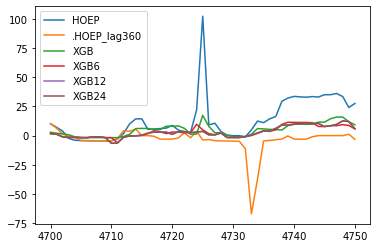

In [2]:
from sklearn.metrics import mean_squared_error
from numpy import corrcoef
import matplotlib.pyplot as plt 
df = data.loc[:8759]

RMSE_lag24 = np.sqrt(mean_squared_error(df.HOEP,df.HOEP_lag24))
print("RMSE HOEP_lag24:",round(RMSE_lag24,2),"Correlation:", corrcoef(df.HOEP,df.HOEP_lag24)[0,1])

RMSE_lag168 = np.sqrt(mean_squared_error(df.HOEP,df.HOEP_lag168))
print("RMSE HOEP_lag168:",round(RMSE_lag168,2),"Correlation:", corrcoef(df.HOEP,df.HOEP_lag168)[0,1])

RMSE_lag360 = np.sqrt(mean_squared_error(df.HOEP,df.HOEP_lag360))
print("RMSE HOEP_lag360:",round(RMSE_lag360,2), "Correlation:", corrcoef(df.HOEP,df.HOEP_lag360)[0,1])

RMSE_XGB = np.sqrt(mean_squared_error(df.HOEP,df.XGB))
print("RMSE XGB:",round(RMSE_XGB,2),"Correlation:", corrcoef(df.HOEP,df.XGB)[0,1])

RMSE_XGB6 = np.sqrt(mean_squared_error(df.HOEP,df.XGB6))
print("RMSE XGB6:",round(RMSE_XGB6,2),"Correlation:", corrcoef(df.HOEP,df.XGB6)[0,1])

RMSE_XGB12 = np.sqrt(mean_squared_error(df.HOEP,df.XGB12))
print("RMSE XGB12:",round(RMSE_XGB12,2),"Correlation:", corrcoef(df.HOEP,df.XGB12)[0,1])

RMSE_XGB13 = np.sqrt(mean_squared_error(df.HOEP,df.XGB13))
print("RMSE XGB13:",round(RMSE_XGB13,2),"Correlation:", corrcoef(df.HOEP,df.XGB13)[0,1])

RMSE_XGB24 = np.sqrt(mean_squared_error(df.HOEP,df.XGB24))
print("RMSE XGB24:",round(RMSE_XGB24,2),"Correlation:", corrcoef(df.HOEP,df.XGB24)[0,1])

test = df.loc[4700:4750]
plt.plot(test.HOEP, label = 'HOEP')
#plt.plot(test.HOEP_lag24, label = '.HOEP_lag24')
#plt.plot(test.HOEP_lag168, label = '.HOEP_lag168')
plt.plot(test.HOEP_lag360, label = '.HOEP_lag360')
plt.plot(test.XGB, label = 'XGB')
plt.plot(test.XGB6, label = 'XGB6')
plt.plot(test.XGB12, label = 'XGB12')
plt.plot(test.XGB12, label = 'XGB24')
plt.legend(loc='best')
plt.show()